In [1]:
from bisect import bisect_left
from collections import Counter, OrderedDict
from itertools import accumulate
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import multiprocessing as mp

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Hello World").getOrCreate()

In [3]:
COLUMNS = (
    ('DevType', True),
    ('FormalEducation', False),
    ('UndergradMajor', False),
    ('Age', False),
    ('LanguageWorkedWith', True),
    ('LanguageDesireNextYear', True),
    ('DatabaseWorkedWith', True),
    ('DatabaseDesireNextYear', True),
    ('PlatformWorkedWith', True),
    ('PlatformDesireNextYear', True),
    ('FrameworkWorkedWith', True),
    ('FrameworkDesireNextYear', True),
    ('IDE', True),
    ('OperatingSystem', False),
    ('CommunicationTools', True),
    ('NumberMonitors', False),
    ('Methodology', True),
    ('VersionControl', True),
)

In [4]:
data_raw = pd.read_csv('survey_results_public.csv', low_memory=False)

In [5]:
data_raw.head()

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


In [6]:
data_raw.describe()

,Respondent,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,...,JobEmailPriorities6,JobEmailPriorities7,ConvertedSalary,AdsPriorities1,AdsPriorities2,AdsPriorities3,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7
count,98855.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,...,46213.00000,46213.000000,4.770200e+04,60479.000000,60479.000000,60479.000000,60479.000000,60479.000000,60479.000000,60479.000000
mean,50822.971635,6.397089,6.673524,5.906875,4.065791,3.953243,4.407196,5.673181,4.225200,7.640009,...,4.97425,4.836388,9.578086e+04,2.726880,3.805784,3.340945,3.782470,4.383604,5.138809,4.821459
std,29321.650410,2.788428,2.531202,2.642734,2.541196,2.520499,2.502069,2.923998,2.507411,2.407457,...,1.86063,1.659844,2.023482e+05,1.881078,1.821323,1.673485,1.844864,1.931746,1.853249,1.874895
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,25443.500000,4.000000,5.000000,4.000000,2.000000,2.000000,2.000000,3.000000,2.000000,6.000000,...,4.00000,4.000000,2.384400e+04,1.000000,2.000000,2.000000,2.000000,3.000000,4.000000,3.000000
50%,50823.000000,7.000000,7.000000,6.000000,4.000000,3.000000,4.000000,6.000000,4.000000,8.000000,...,5.00000,5.000000,5.507500e+04,2.000000,4.000000,3.000000,4.000000,5.000000,6.000000,5.000000
75%,76219.500000,9.000000,9.000000,8.000000,6.000000,6.000000,6.000000,8.000000,6.000000,10.000000,...,7.00000,6.000000,9.300000e+04,4.000000,5.000000,5.000000,5.000000,6.000000,7.000000,7.000000
max,101592.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,7.00000,7.000000,2.000000e+06,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [7]:
data = data_raw[data_raw['LanguageWorkedWith'].str.contains('Python').isin([True])]

In [8]:
len(data_raw), len(data), '{:.1f}%'.format(len(data) / len(data_raw) * 100)

(98855, 30359, '30.7%')

In [9]:
def calc_summary(series, sep=';', labeled_ratio=0.9):
    count_dict = Counter(
        ide for ides in series.str.split(sep)
            if isinstance(ides, list)
            for ide in ides
    )
    count = count_dict.most_common()

    labeled_total_count = sum(x[1] for x in count) * labeled_ratio
    accumulated_counts = list(accumulate(x[1] for x in count))
    index = bisect_left(accumulated_counts, labeled_total_count)
    
    count_tops, count_others = count[:index], count[index:]
    count_tops.append(('others', sum(x[1] for x in count_others)))
    
    return count_tops

In [10]:
def prepare_pie(count_summary):
    labels, values = zip(*count_summary)
    options = {
        'counterclock': False,
        'startangle': 90,
        'autopct': '%.0f%%',
    }

    fig, ax = plt.subplots()
    ax.pie(values, labels=labels, **options)

    ax.axis('equal')

In [11]:
def prepare_bar_horizontal(count_summary, total, ratio_margin=None):
    labels, values = zip(*count_summary)
    indices = np.arange(len(labels))

    fig, ax = plt.subplots()
    ax.barh(indices, values)

    ax.set_yticks(indices)
    ax.set_yticklabels(labels)

    ax.invert_yaxis()
    
    plt.xlim(0, total)
    
    if not ratio_margin:
        ratio_margin = total / 50
    for i, v in zip(indices, values):
        ax.text(min(total, v) + ratio_margin, i + 0.2, '{:2.0f}%'.format(v / total * 100))

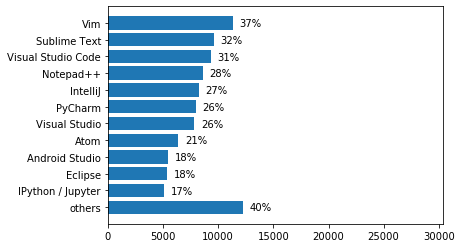

In [12]:
data_ide = data['IDE']
prepare_bar_horizontal(calc_summary(data_ide), len(data_ide))

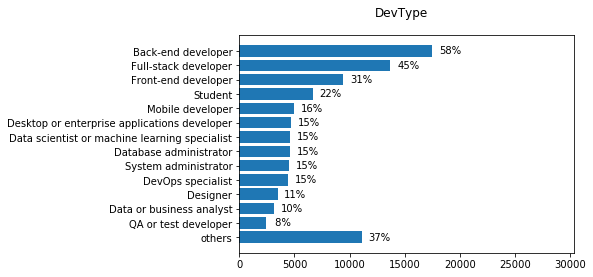

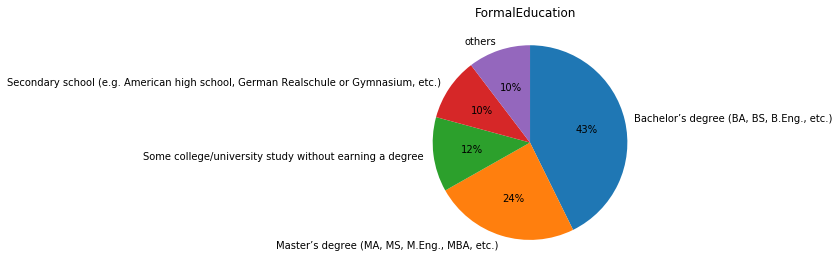

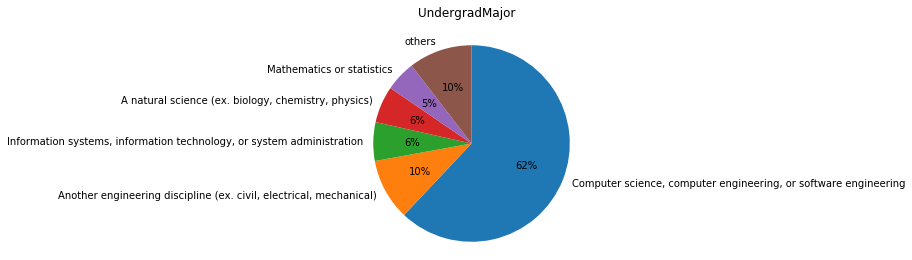

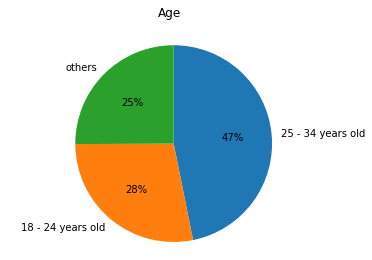

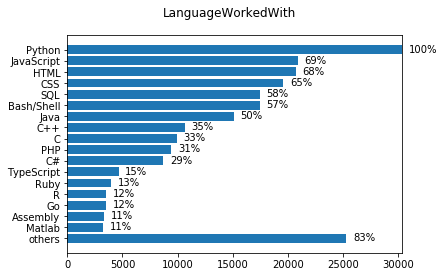

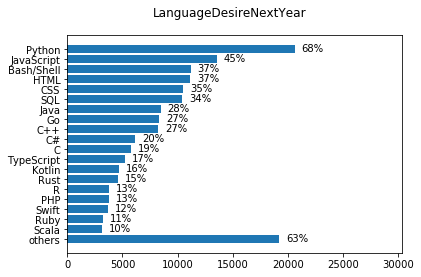

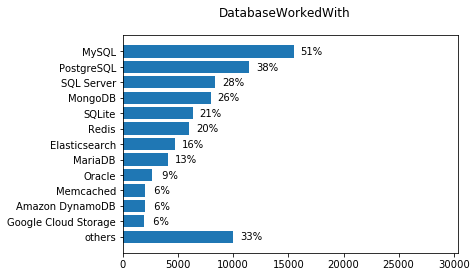

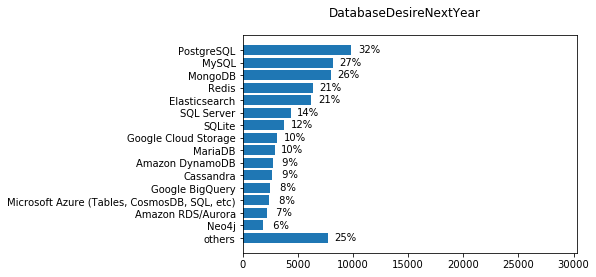

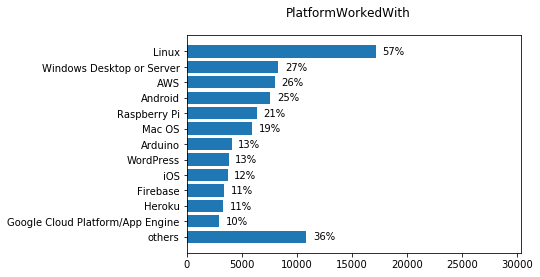

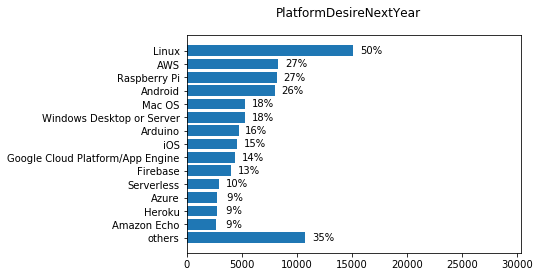

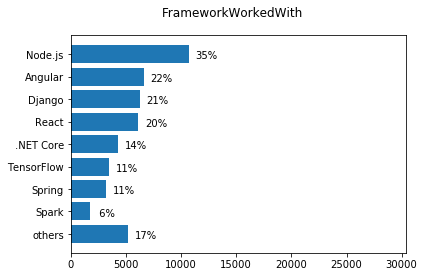

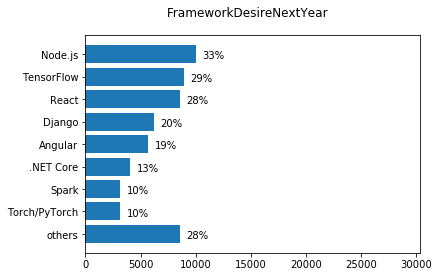

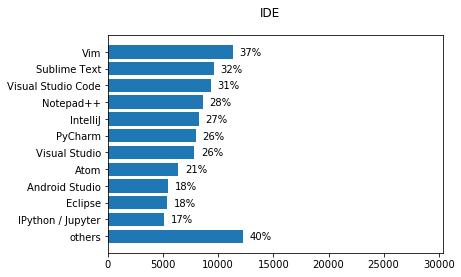

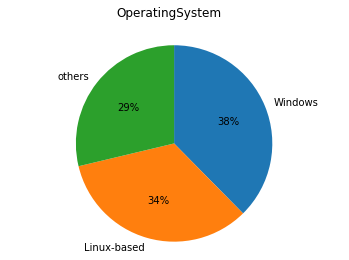

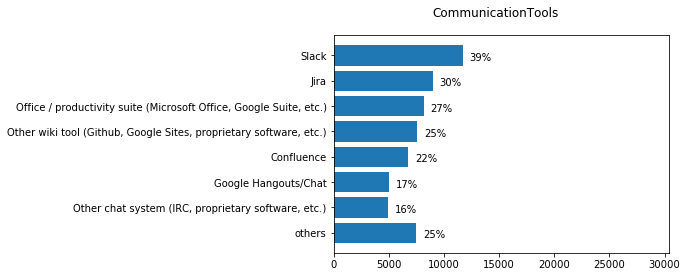

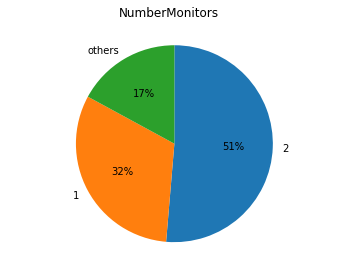

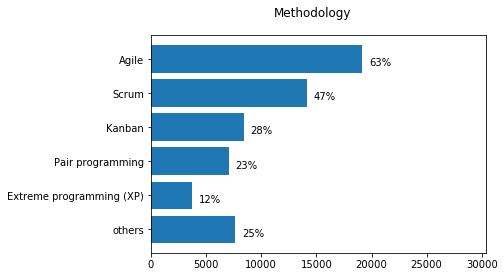

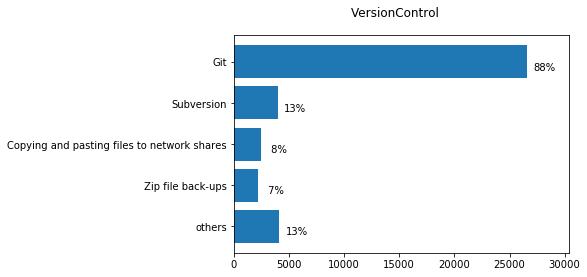

In [13]:
data_count = len(data)
for column, is_multiple in COLUMNS:
    if is_multiple:
        prepare_bar_horizontal(calc_summary(data[column]), data_count)
    else:
        prepare_pie(calc_summary(data[column]))

    plt.suptitle(column)

In [14]:
df = spark.read.format("csv").option("header", "true").load("survey_results_public.csv") 

In [15]:
from pyspark.sql.functions import col
for i in df.columns:
    df = df.where(col(i).isNotNull())

In [16]:
df = df.select(['DevType',
'FormalEducation',
'UndergradMajor',
'Age',
'LanguageWorkedWith',
'LanguageDesireNextYear',
'DatabaseWorkedWith',
'DatabaseDesireNextYear',
'PlatformWorkedWith',
'PlatformDesireNextYear',
'FrameworkWorkedWith',
'FrameworkDesireNextYear',
'IDE',
'OperatingSystem',
'CommunicationTools',
'NumberMonitors',
'Methodology',
'VersionControl'])

In [17]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

def get_dummy(df,categoricalCols):

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categoricalCols ]

    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders], outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    return data.select('features')

In [18]:
df1 = get_dummy(df, df.columns)

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures",maxCategories=6).fit(df1)

data = featureIndexer.transform(df1)

In [20]:
data.show()

+--------------------+--------------------+
|            features|     indexedFeatures|
+--------------------+--------------------+
|(117272,[2,9568,9...|(117272,[2,9568,9...|
|(117272,[551,9568...|(117272,[551,9568...|
|(117272,[69,9573,...|(117272,[69,9573,...|
|(117272,[2,9568,9...|(117272,[2,9568,9...|
|(117272,[7026,957...|(117272,[7026,957...|
|(117272,[25,9568,...|(117272,[25,9568,...|
|(117272,[3,9570,9...|(117272,[3,9570,9...|
|(117272,[366,9568...|(117272,[366,9568...|
|(117272,[6687,957...|(117272,[6687,957...|
|(117272,[65,9568,...|(117272,[65,9568,...|
|(117272,[959,9569...|(117272,[959,9569...|
|(117272,[3,9568,9...|(117272,[3,9568,9...|
|(117272,[9,9570,9...|(117272,[9,9570,9...|
|(117272,[6,9568,9...|(117272,[6,9568,9...|
|(117272,[45,9571,...|(117272,[45,9571,...|
|(117272,[2,9569,9...|(117272,[2,9569,9...|
|(117272,[5,9568,9...|(117272,[5,9568,9...|
|(117272,[1,9569,9...|(117272,[1,9569,9...|
|(117272,[1265,956...|(117272,[1265,956...|
|(117272,[258,9568...|(117272,[2

In [21]:
from pyspark.ml.clustering import KMeans
cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("indexedFeatures").setPredictionCol("cluster")
    model = kmeans.fit(data)
    cost[k] = model.computeCost(data)
    print("For cluster numbers {} / 9 =======================> cost: {}".format(k, cost[k]))

For cluster numbers 2 / 9 =======================> cost: 1249643.459289106
For cluster numbers 3 / 9 =======================> cost: 1220419.4585063886
For cluster numbers 4 / 9 =======================> cost: 1204015.4773393646
For cluster numbers 5 / 9 =======================> cost: 1182213.2360616021
For cluster numbers 6 / 9 =======================> cost: 1177144.9996132243
For cluster numbers 7 / 9 =======================> cost: 1181993.6609906256
For cluster numbers 8 / 9 =======================> cost: 1159067.9993761592
For cluster numbers 9 / 9 =======================> cost: 1163063.9633188925


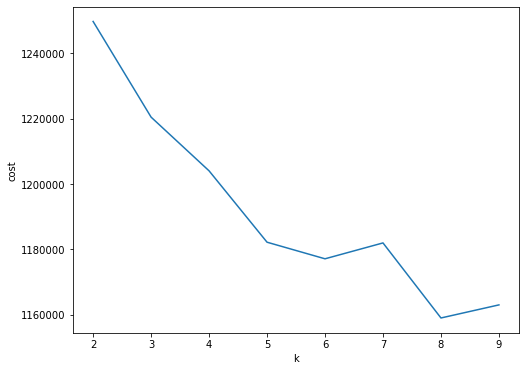

In [22]:
import matplotlib.mlab as mlab
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),cost[2:10])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [23]:
kmeans = KMeans().setK(5).setFeaturesCol("indexedFeatures").setPredictionCol("cluster")

pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(df1)

cluster = model.transform(df1)

In [24]:
cluster.show()

+--------------------+--------------------+-------+
|            features|     indexedFeatures|cluster|
+--------------------+--------------------+-------+
|(117272,[2,9568,9...|(117272,[2,9568,9...|      3|
|(117272,[551,9568...|(117272,[551,9568...|      1|
|(117272,[69,9573,...|(117272,[69,9573,...|      2|
|(117272,[2,9568,9...|(117272,[2,9568,9...|      0|
|(117272,[7026,957...|(117272,[7026,957...|      0|
|(117272,[25,9568,...|(117272,[25,9568,...|      1|
|(117272,[3,9570,9...|(117272,[3,9570,9...|      1|
|(117272,[366,9568...|(117272,[366,9568...|      3|
|(117272,[6687,957...|(117272,[6687,957...|      3|
|(117272,[65,9568,...|(117272,[65,9568,...|      2|
|(117272,[959,9569...|(117272,[959,9569...|      2|
|(117272,[3,9568,9...|(117272,[3,9568,9...|      2|
|(117272,[9,9570,9...|(117272,[9,9570,9...|      2|
|(117272,[6,9568,9...|(117272,[6,9568,9...|      1|
|(117272,[45,9571,...|(117272,[45,9571,...|      4|
|(117272,[2,9569,9...|(117272,[2,9569,9...|      2|
|(117272,[5,

In [25]:
clus = cluster.selectExpr("features as features", "indexedFeatures as indexedFeatures", "cluster as prediction")
clus.show()

+--------------------+--------------------+----------+
|            features|     indexedFeatures|prediction|
+--------------------+--------------------+----------+
|(117272,[2,9568,9...|(117272,[2,9568,9...|         3|
|(117272,[551,9568...|(117272,[551,9568...|         1|
|(117272,[69,9573,...|(117272,[69,9573,...|         2|
|(117272,[2,9568,9...|(117272,[2,9568,9...|         0|
|(117272,[7026,957...|(117272,[7026,957...|         0|
|(117272,[25,9568,...|(117272,[25,9568,...|         1|
|(117272,[3,9570,9...|(117272,[3,9570,9...|         1|
|(117272,[366,9568...|(117272,[366,9568...|         3|
|(117272,[6687,957...|(117272,[6687,957...|         3|
|(117272,[65,9568,...|(117272,[65,9568,...|         2|
|(117272,[959,9569...|(117272,[959,9569...|         2|
|(117272,[3,9568,9...|(117272,[3,9568,9...|         2|
|(117272,[9,9570,9...|(117272,[9,9570,9...|         2|
|(117272,[6,9568,9...|(117272,[6,9568,9...|         1|
|(117272,[45,9571,...|(117272,[45,9571,...|         4|
|(117272,[

In [26]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(clus)
print("Silhouette with squared euclidean distance = " + str(silhouette))

centers = model.stages[1].clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.17204273669754783
Cluster Centers: 
[1.06356040e-02 5.64277876e-02 8.72372753e-02 ... 4.22047776e-05
 0.00000000e+00 4.22047776e-05]
[0.01212838 0.08349753 0.06068567 ... 0.         0.         0.        ]
[0.23888964 0.06211041 0.05515942 ... 0.         0.         0.        ]
[9.89753144e-03 7.51630182e-02 6.34606428e-02 ... 0.00000000e+00
 5.82207732e-05 0.00000000e+00]
[0.05690044 0.03868607 0.02576477 ... 0.         0.         0.        ]
